In [1]:
from tensorflow.config.experimental import list_physical_devices,set_memory_growth
# Get the list of GPUs
gpus = list_physical_devices('GPU')

if gpus:
    try:
        # Allow GPU memory growth
        for gpu in gpus:
            set_memory_growth(gpu, True)
        print("GPU memory growth set successfully.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available.")

2024-05-29 19:07:07.540011: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-29 19:07:09.678881: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


GPU memory growth set successfully.


2024-05-29 19:07:13.840369: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-29 19:07:14.435846: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-29 19:07:14.435912: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [47]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras_cv.layers import RandomShear
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os

class LetterClassifier:
    def __init__(self, data_dir, img_height=28, img_width=28, batch_size=32):
        self.data_dir = data_dir
        self.img_height = img_height
        self.img_width = img_width
        self.batch_size = batch_size
        self.train_ds = None
        self.val_ds = None
        self.model = None
        self.history = None
        self.class_names = []
        self.data_augmentation = self.data_augmentation_layer()
        self.best_model_path = None

    def load_data(self):
        self.train_ds = image_dataset_from_directory(
            self.data_dir,
            validation_split=0.2,
            subset="training",
            seed=123,
            color_mode='grayscale',
            image_size=(self.img_height, self.img_width),
            batch_size=self.batch_size
        )
        
        self.val_ds = image_dataset_from_directory(
            self.data_dir,
            validation_split=0.2,
            subset="validation",
            seed=123,
            color_mode='grayscale',
            image_size=(self.img_height, self.img_width),
            batch_size=self.batch_size
        )
        
        self.class_names = self.train_ds.class_names
        print(self.class_names)

    def show_sample_images(self):
        plt.figure(figsize=(10, 10))
        for images, labels in self.train_ds.take(1):
            for i in range(9):
                ax = plt.subplot(3, 3, i + 1)
                plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
                plt.title(self.class_names[labels[i]])
                plt.axis("off")
        plt.show()

    def data_augmentation_layer(self):
        data_augmentation = tf.keras.Sequential([
            layers.RandomRotation(0.03, input_shape=(self.img_height, self.img_width, 1)),
            RandomShear((0.2, 0.2)),
            layers.Resizing(self.img_height, self.img_width),
            layers.RandomZoom(0.2),
        ])
        return data_augmentation

    def show_augmented_images(self):
        plt.figure(figsize=(10, 10))
        for images, _ in self.train_ds.take(1):
            for i in range(9):
                augmented_images = self.data_augmentation(images)
                ax = plt.subplot(3, 3, i + 1)
                plt.imshow(augmented_images[0].numpy().astype("uint8"), cmap='gray')
                plt.axis("off")
        plt.subplot(3, 3, 1)
        plt.imshow(images[0].numpy().astype("uint8"), cmap='gray')
        plt.axis("off")
        plt.show()

    def build_model(self):
        kernel_regularizer = regularizers.l2(0.1)
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-1)
        loss_function = 'sparse_categorical_crossentropy'

        self.model = models.Sequential([
            self.data_augmentation,
            layers.Rescaling(1./255),
            layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
            layers.BatchNormalization(),
            layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
            layers.BatchNormalization(),
            layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Flatten(),
            layers.Dense(128, activation='relu', kernel_regularizer=kernel_regularizer),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(len(self.class_names), activation='softmax')
        ])

        self.model.compile(optimizer=optimizer,
                           loss=loss_function,
                           metrics=['accuracy'])
        
        self.model.summary()

    def train_model(self, epochs=300):
        now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        self.best_model_path = f"models/best_model_{now}.keras"
        
        early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint(self.best_model_path, monitor="val_accuracy", save_best_only=True)
        reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)

        callbacks = [early_stopping, model_checkpoint, reduce_lr]

        self.history = self.model.fit(
            self.train_ds,
            validation_data=self.val_ds,
            epochs=epochs,
            callbacks=callbacks
        )

    def load_best_model(self, path=None):
        if path == None:
            path=self.best_model_path
        if os.path.exists(path):
            self.model = models.load_model(path)
            print(f"Loaded best model from {path}")
        else:
            print("Best model path is not set or model file does not exist")

    def evaluate_model(self):
        if self.model is None:
            raise ValueError("Model is not built or loaded.")
        
        loss, accuracy = self.model.evaluate(self.val_ds)
        print(f"Accuracy: {accuracy*100:.2f}%")
        
        acc = self.history.history['accuracy']
        val_acc = self.history.history['val_accuracy']
        loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']

        plt.figure(figsize=(8, 8))
        plt.subplot(1, 2, 1)
        plt.plot(acc, label='Training Accuracy')
        plt.plot(val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(loss, label='Training Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.show()

    def predict_image(self, image_path):
        if self.model is None:
            raise ValueError("Model is not built or loaded.")
        
        img = tf.keras.utils.load_img(
            image_path, target_size=(self.img_height, self.img_width), color_mode='grayscale'
        )
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)

        predictions = self.model.predict(img_array)
        score = tf.nn.softmax(predictions[0])

        print(
            "This image most likely belongs to {} with a {:.2f} percent confidence."
            .format(self.class_names[np.argmax(score)], 100 * np.max(score))
        )
        plt.imshow(img, cmap='gray')
        plt.title("Loaded Image")
        plt.axis("off")
        plt.show()
    
    def predict_folder(self, folder_path):
        if os.path.exists(folder_path):
            # Pobranie listy plików w folderze
            image_files = [file for file in os.listdir(folder_path) if file.endswith('.png')]
            for image_file in image_files:
                # Tworzenie pełnej ścieżki do pliku
                image_path = os.path.join(folder_path, image_file)
                
                # Wywołanie funkcji process_image dla każdego obrazu
                self.predict_image(image_path)
            else:
                print("Podana ścieżka do folderu nie istnieje.")


In [48]:
classifier = LetterClassifier(data_dir='data_classificator')

/home/user/.local/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [49]:
classifier.load_data()

Found 720 files belonging to 36 classes.
Using 576 files for training.
Found 720 files belonging to 36 classes.
Using 144 files for validation.
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


2024-05-28 14:11:48.844380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


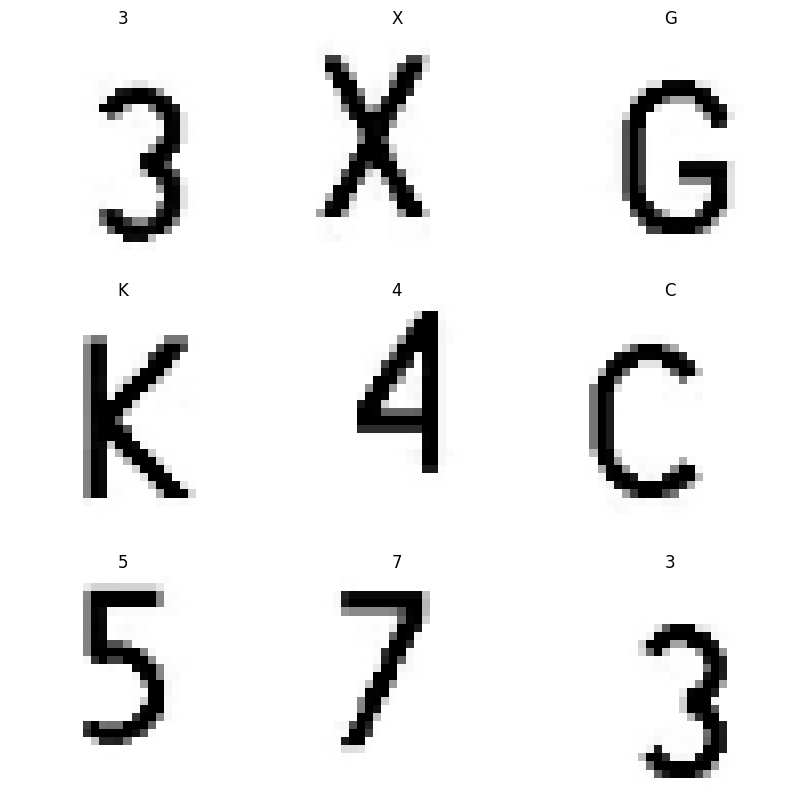

In [6]:
# Wyświetlenie przykładowych obrazów
classifier.show_sample_images()

2024-05-28 14:11:57.493090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


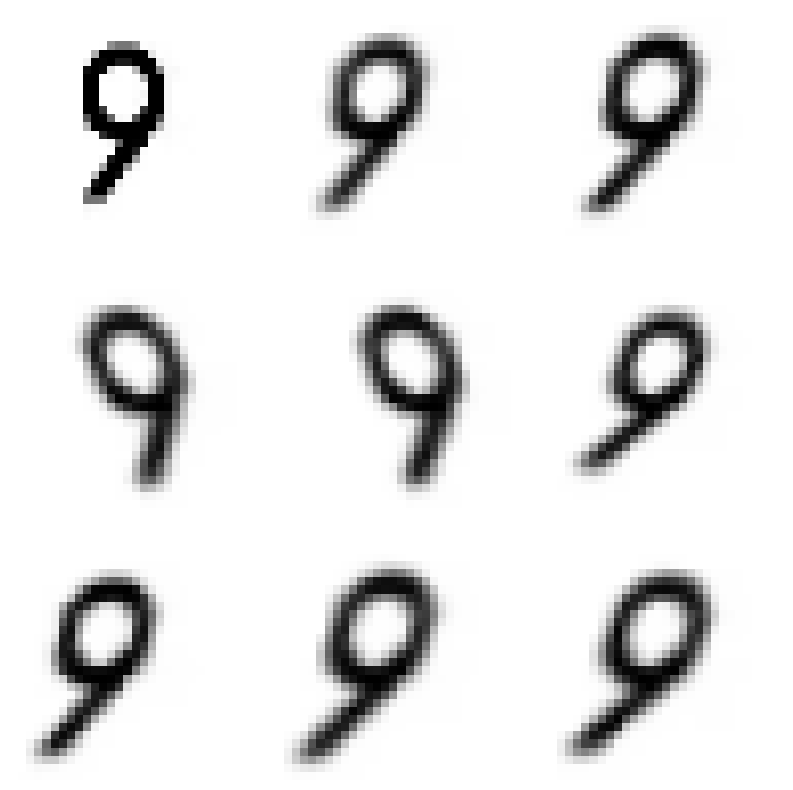

In [7]:
classifier.show_augmented_images()

In [8]:
classifier.build_model()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Trenowanie modelu
classifier.train_model(epochs=300)

Epoch 1/300


2024-05-28 14:12:40.007763: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-05-28 14:12:41.290427: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 297ms/step - accuracy: 0.0402 - loss: 4773.5391 - val_accuracy: 0.0208 - val_loss: 1031.9204 - learning_rate: 0.1000
Epoch 2/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 246ms/step - accuracy: 0.0473 - loss: 711.2946 - val_accuracy: 0.0278 - val_loss: 351.3293 - learning_rate: 0.1000
Epoch 3/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - accuracy: 0.0684 - loss: 255.7517 - val_accuracy: 0.0278 - val_loss: 135.7049 - learning_rate: 0.1000
Epoch 4/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - accuracy: 0.0705 - loss: 126.4759 - val_accuracy: 0.0278 - val_loss: 136.9606 - learning_rate: 0.1000
Epoch 5/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 0.0668 - loss: 145.8766 - val_accuracy: 0.0208 - val_loss: 179.0143 - learning_rate: 0.1000
Epoch 6/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 243ms/step - accuracy: 0.0496 - loss: 143.1140 - val_accuracy: 0.0417 - val_loss: 174.4814 - learning_rate: 0.1000
Epoch 7/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8691 - loss: 1.8157
Accuracy: 86.11%


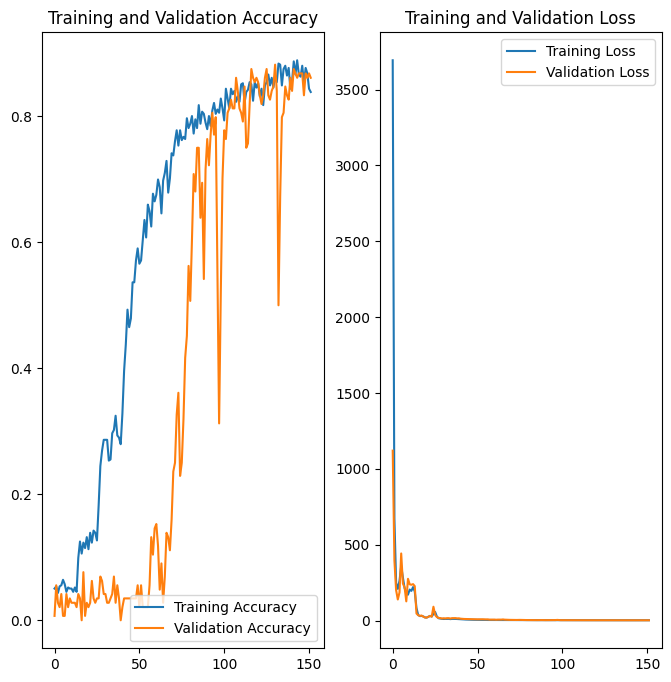

In [37]:
classifier.evaluate_model()

In [50]:
classifier.load_best_model("models/best_model_2024-05-28_14-12-34.keras")

Loaded best model from models/best_model_2024-05-28_14-12-34.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
This image most likely belongs to W with a 7.21 percent confidence.


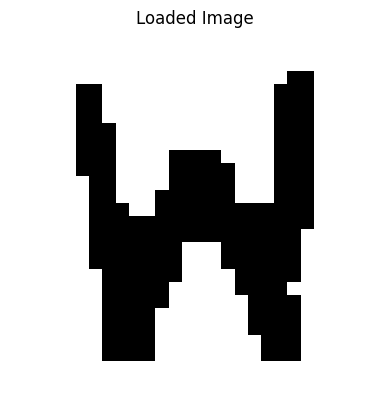

In [51]:
classifier.predict_image('better_data/crop/image_00/crop_1.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
This image most likely belongs to D with a 6.88 percent confidence.


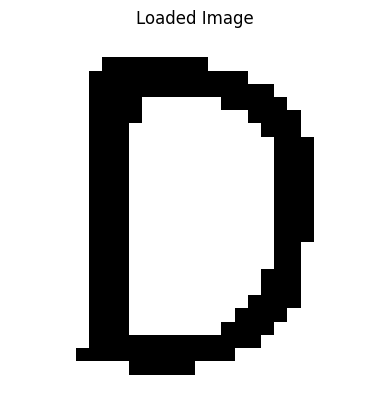

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
This image most likely belongs to W with a 7.21 percent confidence.


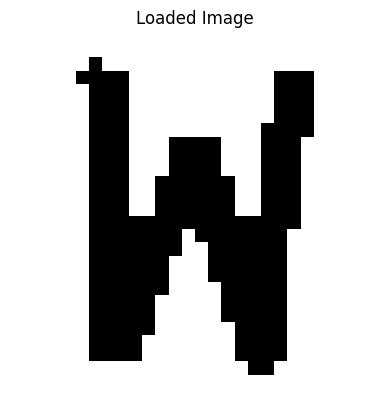

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
This image most likely belongs to R with a 5.88 percent confidence.


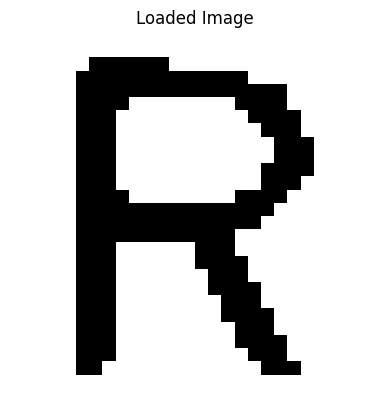

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
This image most likely belongs to W with a 4.53 percent confidence.


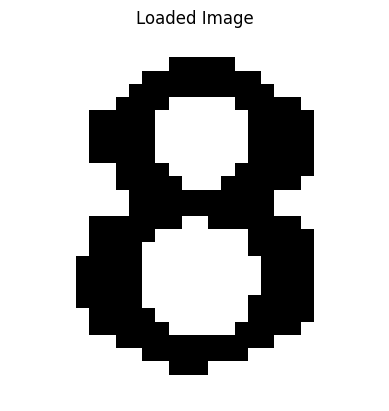

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
This image most likely belongs to M with a 6.31 percent confidence.


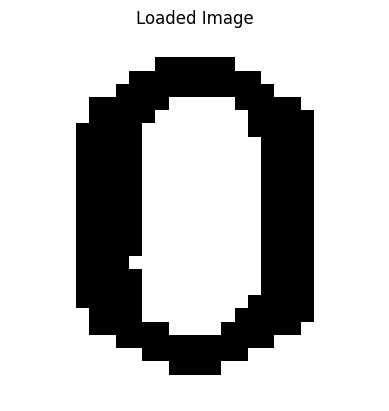

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
This image most likely belongs to M with a 5.86 percent confidence.


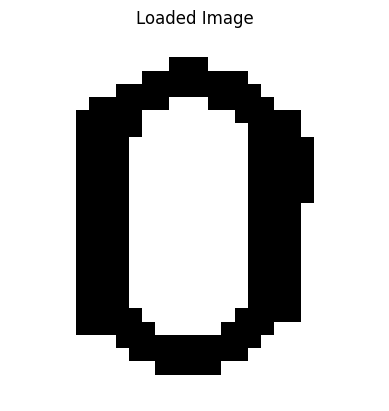

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
This image most likely belongs to M with a 5.56 percent confidence.


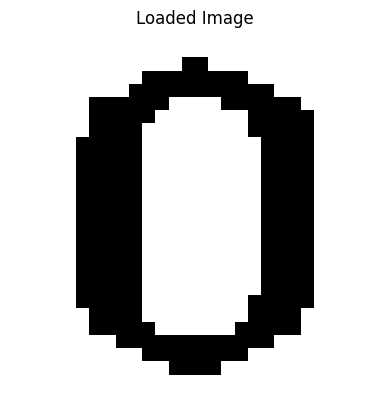

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
This image most likely belongs to J with a 6.04 percent confidence.


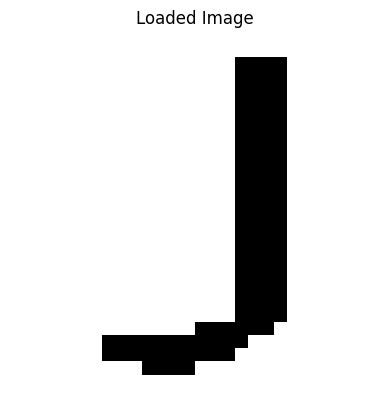

Podana ścieżka do folderu nie istnieje.


In [54]:
folder_path = 'better_data/crop/image_02'
classifier.predict_folder(folder_path=folder_path)